In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d barelydedicated/bank-customer-churn-modeling

  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 36.5MB/s]


In [7]:
!mkdir bank-customer-churn-modeling

In [8]:
! unzip bank-customer-churn-modeling.zip -d bank-customer-churn-modeling

Archive:  bank-customer-churn-modeling.zip
  inflating: bank-customer-churn-modeling/Churn_Modelling.csv  


In [9]:
!pip install scikit-learn==0.22.0

     |████████████████████████████████| 7.0MB 5.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

import os
print(os.listdir("/content"))

['.config', 'bank-customer-churn-modeling', '.ipynb_checkpoints', 'kaggle.json', 'sample_data']


## Data Preprocessing

In [11]:
#importing the dataset
dataset = pd.read_csv('/content/bank-customer-churn-modeling/Churn_Modelling.csv', index_col='RowNumber')
dataset.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
X_columns = dataset.columns.tolist()[2:12]
y_columns = dataset.columns.tolist()[-1:]
print(f'All columns: {dataset.columns.tolist()}')
print()
print(f'X values: {X_columns}')
print()
print(f'y values: {y_columns}')

All columns: ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

X values: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

y values: ['Exited']


In [13]:
X = dataset[X_columns].values # Credit Score through Estimated Salary
y = dataset[y_columns].values # Exited

In [14]:
# Encoding categorical (string based) data. Country: there are 3 options: France, Spain and Germany
# This will convert those strings into scalar values for analysis
print(X[:8,1], '... will now become: ')
from sklearn.preprocessing import LabelEncoder
label_X_country_encoder = LabelEncoder()
X[:,1] = label_X_country_encoder.fit_transform(X[:,1])
print(X[:8,1])

['France' 'Spain' 'France' 'France' 'Spain' 'Spain' 'France' 'Germany'] ... will now become: 
[0 2 0 0 2 2 0 1]


In [15]:
# We will do the same thing for gender. this will be binary in this dataset
print(X[:6,2], '... will now become: ')
from sklearn.preprocessing import LabelEncoder
label_X_gender_encoder = LabelEncoder()
X[:,2] = label_X_gender_encoder.fit_transform(X[:,2])
print(X[:6,2])

['Female' 'Female' 'Female' 'Female' 'Female' 'Male'] ... will now become: 
[0 0 0 0 0 1]


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


pipeline = Pipeline(
    [('Categorizer', ColumnTransformer(
         [ # Gender
          ("Gender Label encoder", OneHotEncoder(categories='auto', drop='first'), [2]),
           # Geography
          ("Geography One Hot", OneHotEncoder(categories='auto', drop='first'), [1])
         ], remainder='passthrough', n_jobs=1)),
     # Standard Scaler for the classifier
    ('Normalizer', StandardScaler())
    ])

In [17]:
X = pipeline.fit_transform(X)

In [18]:
# Splitting the dataset into the Training and Testing set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [19]:
print(f'training shapes: {X_train.shape}, {y_train.shape}')
print(f'testing shapes: {X_test.shape}, {y_test.shape}')

training shapes: (8000, 11), (8000, 1)
testing shapes: (2000, 11), (2000, 1)


## END OF PREPROCESSING

### Making the NN

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [21]:
# Initializing the ANN
classifier = Sequential()

In [22]:
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
classifier.add(Dense(6, activation = 'relu', input_shape = (X_train.shape[1], )))
classifier.add(Dropout(rate=0.1))

In [23]:
# Adding the second hidden layer
# Notice that we do not need to specify input dim. 
classifier.add(Dense(6, activation = 'relu')) 
classifier.add(Dropout(rate=0.1)) 

In [24]:
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
classifier.add(Dense(1, activation = 'sigmoid')) 

In [25]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [26]:
classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

### Fitting the Neural Network

In [27]:
history = classifier.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.1, verbose=2)

Epoch 1/200
225/225 - 1s - loss: 0.6323 - accuracy: 0.6785 - val_loss: 0.5157 - val_accuracy: 0.7925
Epoch 2/200
225/225 - 0s - loss: 0.5009 - accuracy: 0.7939 - val_loss: 0.4634 - val_accuracy: 0.7950
Epoch 3/200
225/225 - 0s - loss: 0.4766 - accuracy: 0.7936 - val_loss: 0.4487 - val_accuracy: 0.7950
Epoch 4/200
225/225 - 0s - loss: 0.4665 - accuracy: 0.7957 - val_loss: 0.4368 - val_accuracy: 0.7950
Epoch 5/200
225/225 - 0s - loss: 0.4549 - accuracy: 0.7957 - val_loss: 0.4240 - val_accuracy: 0.7912
Epoch 6/200
225/225 - 0s - loss: 0.4483 - accuracy: 0.8008 - val_loss: 0.4134 - val_accuracy: 0.8050
Epoch 7/200
225/225 - 0s - loss: 0.4392 - accuracy: 0.8057 - val_loss: 0.4038 - val_accuracy: 0.8238
Epoch 8/200
225/225 - 0s - loss: 0.4333 - accuracy: 0.8132 - val_loss: 0.3975 - val_accuracy: 0.8325
Epoch 9/200
225/225 - 0s - loss: 0.4307 - accuracy: 0.8186 - val_loss: 0.3934 - val_accuracy: 0.8363
Epoch 10/200
225/225 - 0s - loss: 0.4256 - accuracy: 0.8183 - val_loss: 0.3896 - val_accura

## Testing the NN

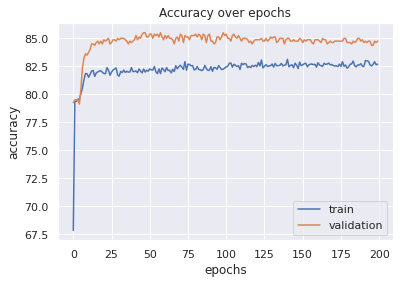

In [30]:
plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

In [33]:
y_pred = classifier.predict(X_test)
print(y_pred[:5])

[[0.32255864]
 [0.37977296]
 [0.21644095]
 [0.08747739]
 [0.08317208]]


In [34]:
y_pred = (y_pred > 0.5).astype(int)
print(y_pred[:5])

[[0]
 [0]
 [0]
 [0]
 [0]]


In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1542   53]
 [ 268  137]]


In [36]:
print (((cm[0][0]+cm[1][1])*100)/(len(y_test)), '% of testing data was classified correctly')

83.95 % of testing data was classified correctly


In [37]:
classifier.save("customer_exit_orNOT_bank.h5")